# Sentiment Analysis: Using Recurrent Neural Networks
:label:`sec_sentiment_rnn`


Similar to search synonyms and analogies, text classification is also a
downstream application of word embedding. In this section, we will apply
pretrained word vectors (GloVe) and bidirectional recurrent neural networks with
multiple hidden layers :cite:`Maas.Daly.Pham.ea.2011`, as shown in :numref:`fig_nlp-map-sa-rnn`. We will use the model to
determine whether a text sequence of indefinite length contains positive or
negative emotion. 

![This section feeds pretrained GloVe to an RNN-based architecture for sentiment analysis.](../img/nlp-map-sa-rnn.svg)
:label:`fig_nlp-map-sa-rnn`


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

## Using a Recurrent Neural Network Model

In this model, each word first obtains a feature vector from the embedding
layer. Then, we further encode the feature sequence using a bidirectional
recurrent neural network to obtain sequence information. Finally, we transform
the encoded sequence information to output through the fully connected
layer. Specifically, we can concatenate hidden states of bidirectional
long-short term memory in the initial time step and final time step and pass it
to the output layer classification as encoded feature sequence information. In
the `BiRNN` class implemented below, the `Embedding` instance is the embedding
layer, the `LSTM` instance is the hidden layer for sequence encoding, and the
`Dense` instance is the output layer for generated classification results.


In [2]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set `bidirectional` to True to get a bidirectional recurrent neural
        # network
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                               bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        # The shape of `inputs` is (batch size, no. of words). Because LSTM
        # needs to use sequence as the first dimension, the input is
        # transformed and the word feature is then extracted. The output shape
        # is (no. of words, batch size, word vector dimension).
        embeddings = self.embedding(inputs.T)
        # Since the input (embeddings) is the only argument passed into
        # nn.LSTM, both h_0 and c_0 default to zero.
        # we only use the hidden states of the last hidden layer
        # at different time step (outputs). The shape of `outputs` is
        # (no. of words, batch size, 2 * no. of hidden units).
        self.encoder.flatten_parameters()
        outputs, _ = self.encoder(embeddings)
        # Concatenate the hidden states of the initial time step and final
        # time step to use as the input of the fully connected layer. Its
        # shape is (batch size, 4 * no. of hidden units)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs

Create a bidirectional recurrent neural network with two hidden layers.


In [3]:
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])

net.apply(init_weights);

### Loading Pretrained Word Vectors

Because the training dataset for sentiment classification is not very large, in order to deal with overfitting, we will directly use word vectors pretrained on a larger corpus as the feature vectors of all words. Here, we load a 100-dimensional GloVe word vector for each word in the dictionary `vocab`.


In [4]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')

Query the word vectors that in our vocabulary.


In [5]:
embeds = glove_embedding[vocab.idx_to_token]
embeds.shape

torch.Size([49346, 100])

Then, we will use these word vectors as feature vectors for each word in the reviews. Note that the dimensions of the pretrained word vectors need to be consistent with the embedding layer output size `embed_size` in the created model. In addition, we no longer update these word vectors during training.


In [6]:
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

### Training and Evaluating the Model

Now, we can start training.


loss 0.277, train acc 0.886, test acc 0.857
167.6 examples/sec on [device(type='cuda', index=0)]


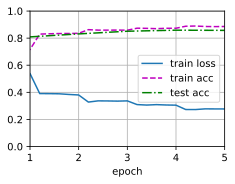

In [7]:
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

Finally, define the prediction function.


In [8]:
#@save
def predict_sentiment(net, vocab, sentence):
    sentence = torch.tensor(vocab[sentence.split()], device=d2l.try_gpu())
    label = torch.argmax(net(sentence.reshape(1, -1)), dim=1)
    return 'positive' if label == 1 else 'negative'

Then, use the trained model to classify the sentiments of two simple sentences.


In [9]:
predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [10]:
predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

## Summary

* Text classification transforms a sequence of text of indefinite length into a category of text. This is a downstream application of word embedding.
* We can apply pretrained word vectors and recurrent neural networks to classify the emotions in a text.


## Exercises

1. Increase the number of epochs. What accuracy rate can you achieve on the training and testing datasets? What about trying to re-tune other hyperparameters?
1. Will using larger pretrained word vectors, such as 300-dimensional GloVe word vectors, improve classification accuracy?
1. Can we improve the classification accuracy by using the spaCy word tokenization tool? You need to install spaCy: `pip install spacy` and install the English package: `python -m spacy download en`. In the code, first import spacy: `import spacy`. Then, load the spacy English package: `spacy_en = spacy.load('en')`. Finally, define the function `def tokenizer(text): return [tok.text for tok in spacy_en.tokenizer(text)]` and replace the original `tokenizer` function. It should be noted that GloVe's word vector uses "-" to connect each word when storing noun phrases. For example, the phrase "new york" is represented as "new-york" in GloVe. After using spaCy tokenization, "new york" may be stored as "new york".


[Discussions](https://discuss.d2l.ai/t/1424)


## My exercise solutions:

3. Can we improve the classification accuracy by using the spaCy word tokenization tool? You need to install spaCy: pip install spacy and install the English package: python -m spacy download en. In the code, first import spacy: import spacy. Then, load the spacy English package: spacy_en = spacy.load('en'). Finally, define the function def tokenizer(text): return [tok.text for tok in spacy_en.tokenizer(text)] and replace the original tokenizer function. It should be noted that GloVe's word vector uses "-" to connect each word when storing noun phrases. For example, the phrase "new york" is represented as "new-york" in GloVe. After using spaCy tokenization, "new york" may be stored as "new york".

In [11]:
import spacy

In [15]:
spacy_en = spacy.load("en_core_web_sm")

In [16]:
def tokenizer(text): 
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [27]:
embeds = tokenizer(vocab.idx_to_token)
len(embeds)

TypeError: Argument 'string' has incorrect type (expected str, got list)

## TODO: Fix the error above; the idea is to get the embeddings from spaCy into the embedding layer as weights (mind the embedding dimensions), but there's some error here related to the tokenizer function

In [6]:
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

loss 0.277, train acc 0.886, test acc 0.857
167.6 examples/sec on [device(type='cuda', index=0)]


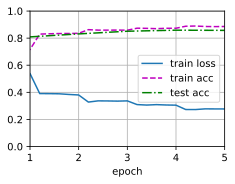

In [7]:
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [8]:
#@save
def predict_sentiment(net, vocab, sentence):
    sentence = torch.tensor(vocab[sentence.split()], device=d2l.try_gpu())
    label = torch.argmax(net(sentence.reshape(1, -1)), dim=1)
    return 'positive' if label == 1 else 'negative'

Then, use the trained model to classify the sentiments of two simple sentences.


In [9]:
predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [10]:
predict_sentiment(net, vocab, 'this movie is so bad')

'negative'